# Supermarket Example

In [10]:
import pandas
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve

Given is a supermarket comprising of on-site energy conversion blocks and energy demands. The expected operating horizon of the supermarket is 20 years. The energy demands are listed in Table 1.

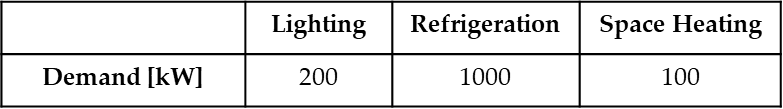

Primary energy resources include natural gas and biomass. Prices of the primary energy resources and grid electricity as well as their associated CO2 production is given in Table 2 – it should be noted that 1 [GJ] is approximately equal to 277.78 [KWh].


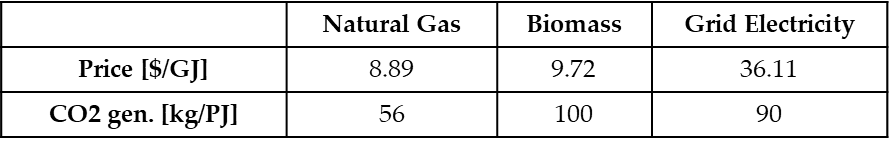

The on-site energy generation section involves two electricity generation technologies, one heat generation technology, and one co-production technology. The electrical efficiency (ηE), heating efficiency (ηH), minimum capacity if constructed (LB), maximum capacity if constructed (UB), capital cost (CAPEX), and operational cost (OPEX) are give in Table 3. Table 3: Technical and economic parameters of on-site energy generation technologies


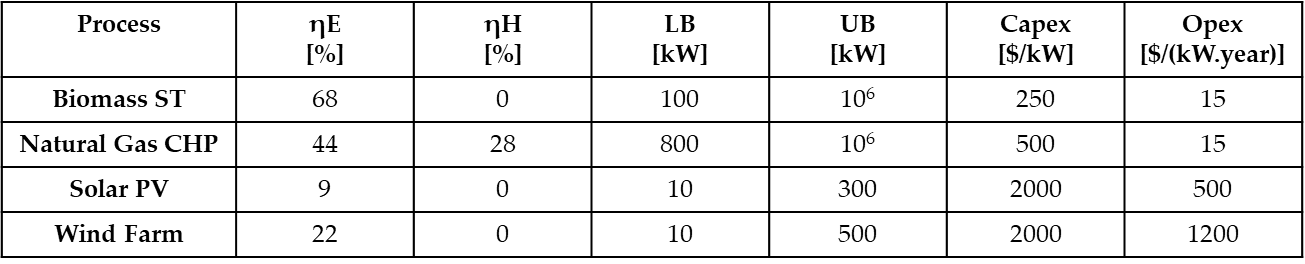

Two electricity driven energy conversion technologies and one heat driven energy conversion technologies is given in order to meet the demands of lighting, refrigeration, and space heating. The efficiency (or coefficient of performance, COP), types of energy input, types of utility output, capital cost and operational cost of these technologies are summarized in Table 4.

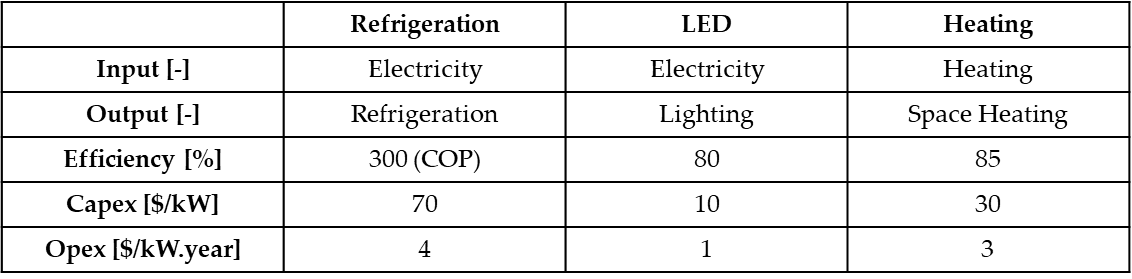

Determine system configurations for optimal cost, energy efficiency, and emission

## Temporal Scale

We will conside a single temporal scale representing the 20 year horizon

In [11]:
scales=TemporalScale(discretization_list=[1]) 

## Resources

Resources can be declared along with thier attributes such as maximum allowed consumption, dischargeablity, base price, etc.

In [12]:
Biomass= Resource(name='Biomass', price=36.11, cons_max= 10**10, basis='GJ', label='Biomass') #table 2

GridPower = Resource(name='GridPower', cons_max = 10**10, price=9.72, basis='GJ', label='Grid Electricity')

NG = Resource(name='NG', price= 8.89, cons_max= 10*10, basis='GJ', label='Natural gas')
Power=Resource(name='Power', basis='kW',label='Electrical Power')
Heat=Resource(name='Heat', basis='kW',label='Heat Power')

CO2_Vent = Resource(name='CO2_Vent', sell=True, basis='tons', label='Carbon dioxide')

Solar = Resource(name = 'Solar', cons_max=10**10, basis ='GJ', label ='Solar energy') 
Wind = Resource(name = 'Wind', cons_max=10**10, basis ='GJ', label ='Wind energy')

Lighting = Resource(name='Lighting', demand=True, basis='kW',label='Lighting')
Refrigeration = Resource(name='Refrigeration', demand=True, basis='kW',label='Refrigeration') 
Heating = Resource(name='Heating', demand=True, basis='kW',label='Heating')


## Processes

Processes convert one resource to another with a particular conversion efficiency while incurring a cost for setup (capital expenditure) and operation (operational expenditure)

In [13]:
ST= Process(name='BM_ST', conversion={Biomass: -1, Power: 277.78*0.68, CO2_Vent:100},capex=250, fopex=15,
            cap_min=100, cap_max=1000000, label='Biomass ST', basis='PJ') #table 3 


CHP= Process(name='NG_CHP', conversion={NG: -1, Power: 277.78*0.44, CO2_Vent: 56, Heat: 277.78*0.28},
             capex=500, fopex=15, cap_max=1000000, cap_min=800, label='Natural Gas CHP', basis='PJ')


PV= Process(name='PV', conversion={Solar: -1, Power: 277.78*0.09}, capex=2000, fopex = 500, 
             cap_max=300, cap_min=10, label='Solar PV',  basis='kW')


WF= Process(name='WF',conversion={Wind: -1, Power: 277.78*0.22}, capex=2000, fopex=1200,
             cap_max=500, cap_min=10, label='Wind Farm', basis='kW') 


Grid = Process(name = 'Grid', conversion = {GridPower:-1, Power:277.78, CO2_Vent:90}, 
               basis = 'PJ', label = 'Grid Electricity', cap_max = 1000)

In [14]:
Refrigerator = Process(name = 'Refrigerator', conversion = {Power:-1, Refrigeration:1*3}, capex = 70, vopex = 4, 
             basis = 'kW', label = 'Refrigerator', cap_max = 1000)

LED = Process(name = 'LED', conversion = {Power:-1, Lighting:1*0.8}, capex = 10, vopex = 1, 
             basis = 'kW', label = 'LED', cap_max = 1000)

Heater = Process(name = 'Heater', conversion = {Heat:-1, Heating:1*0.85}, capex = 30, vopex = 3, 
             basis = 'kW', label = 'Heater', cap_max = 1000)

## Location

Locations serve as aggregations of scenarios

In [15]:
place = Location(name = 'place', processes = {ST, CHP, PV, WF, Grid, Refrigerator, LED, Heater}, 
                 scales = scales, label = 'College Station')

## Scenario

Demands are provided at the scenario level

In [16]:
scenario= Scenario(name='scenario', network=place, 
                   demand= {place:{Heating:100, Lighting:200, Refrigeration:1000}},
                   network_scale_level=0,scheduling_scale_level=0, scales=scales, label='scenario', demand_scale_level = 0, annualization_factor = 0.05)
#26000 is the total power we will need in 20 years running the supermarket


## Formulation

Various constraints are need for the formulating the mathematical programming model. Here we include the cost, production, resource balance, demand, inventory, and network constraints.

### Optimal Cost 

In [18]:
lp=formulate(scenario=scenario, constraints=
            {
            Constraints.COST,
            Constraints.PRODUCTION,
            Constraints.RESOURCE_BALANCE,
            Constraints.DEMAND,
            Constraints.INVENTORY,
            Constraints.NETWORK,
            }, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [20]:
results=solve(scenario= scenario, instance=lp, solver='gurobi', name='lp')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 150 rows, 145 columns and 294 nonzeros
Model fingerprint: 0xc053e7e7
Variable types: 137 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 143 rows and 137 columns
Presolve time: 0.00s
Presolved: 7 rows, 8 columns, 16 nonzeros
Variable types: 6 continuous, 2 integer (2 binary)
Found heuristic solution: objective 35431.801495

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution

In [21]:
results.output['Cap_P']

{('place', 'BM_ST', 0): 0.0,
 ('place', 'Grid', 0): 1000.0,
 ('place', 'Heater', 0): 117.64705882352916,
 ('place', 'LED', 0): 250.0,
 ('place', 'NG_CHP', 0): 800.0,
 ('place', 'PV', 0): 0.0,
 ('place', 'Refrigerator', 0): 333.3333333333333,
 ('place', 'WF', 0): 0.0}

In [22]:
results.output['S']

{('place', 'CO2_Vent', 0): 213.80501224897768,
 ('place', 'Heating', 0): 100.00000000000001,
 ('place', 'Refrigeration', 0): 1000.0,
 ('place', 'Lighting', 0): 200.0}

In [23]:
results.output['P']

{('place', 'WF', 0): 0.0,
 ('place', 'Refrigerator', 0): 333.3333333333333,
 ('place', 'Heater', 0): 117.64705882352942,
 ('place', 'LED', 0): 250.0,
 ('place', 'Grid', 0): 1.4344423059741573,
 ('place', 'NG_CHP', 0): 1.5125929412732766,
 ('place', 'PV', 0): 0.0,
 ('place', 'BM_ST', 0): 0.0}

### Optimal Energy Efficiency 

In the formulation, the objective can be skipped and a bespoke objective can be introduced as shown below

In [25]:
from pyomo.environ import Objective

lp.objective = Objective(expr = sum(lp.C['place', resource_, 0] for resource_ in lp.resources_purch))

### Optimal Emissions